# Assignment Wind and Waves
## Question 1 - FEM Model

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch
import sympy as sym

In [ ]:
# General parameters
M_RNA = 550E3           # RNA Mass [kg]
H = 105                 # Hub height [m]
h = 35                  # Water depth [m]
Omega_max = 11.3        # Max rotor speed [rpm]
F = 200E3               # Fetch [m]
U10 = 23                # Wind speed [m/s]

L = H + h               # Total length [m]
d = 7                   # Diameter [m]
t = 0.01 * d            # Thickness [m]
A = np.pi * d * t       # Cross-sectional area [m^2]
rho = 7850              # Density [kg/m^3]
E = 210E9               # Young's modulus [Pa]
I = np.pi*(d/2)**3*t    # Moment of inertia [m^4]

q = 10                  # Distributed load [N/m]

# Boundary conditions for FEM
u0 = 0          # [m]
u0_dt2 = 0      # [m/s^2]
du0 = 0         # [m]
du0_dt2 = 0     # [m/s^2]


g = 9.81                # Gravitational acceleration [m/s^2]

# Question 3 and 4 parameters
u_star = 2              # Friction Velocity [m/s]
k = 0.40                # Von-Karman constant
z_0 = 1e-3              # Roughness Length [m] 

1980028039833.1375


### Step 1: discretize the domain

In [ ]:
ne = 12
nn = ne + 1
ndofs = 2*nn
xn = np.linspace(0, L, nn)

l_elem = L/12

In [ ]:
elem_dofs = []
dof_node = []
for ie in np.arange(0,ne):
    elem_dofs.append(np.arange(2*ie, 2*ie+4))
for idof in np.arange(0, ndofs):
    dof_node.append(int(np.floor(idof/2)))

In [ ]:
# Define Cubic Shape Functions
N_k = []
dN_k = []
ddN_k = []
h_e = L/ne
matrix = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [1, h_e,  h_e**2, h_e**3], [0, 1, 2*h_e, 3*h_e**2]])

def base(x):
    if isinstance(x, float):
        return np.array([[1], [x], [x**2], [x**3]])
    else:
        return np.array([[np.ones(len(x))], [x], [x**2], [x**3]])
def dbase(x):
    if isinstance(x, float):
        return np.array([[0], [1], [2*x], [3*x**2]])
    else:
        return np.array([[np.zeros(len(x))], [np.ones(len(x))], [2*x], [3*x**2]])
def ddbase(x):
    if isinstance(x, float):
        return np.array([[0], [0], [2], [6*x]])
    else:
        return np.array([[np.zeros(len(x))], [np.zeros(len(x))], [2*np.ones(len(x))], [6*x]])
    
def make_N(coeff): 
    return lambda x: np.dot(np.transpose(base(x)), coeff)
def make_dN(coeff):
    return lambda x: np.dot(np.transpose(dbase(x)), coeff)
def make_ddN(coeff):
    return lambda x: np.dot(np.transpose(ddbase(x)), coeff)

dof_vec = np.arange(0,4)
for idof in dof_vec:
    rhs = np.zeros(len(dof_vec))
    rhs[idof] = 1
    coeff = np.linalg.solve(matrix, rhs)
    N_k.append(make_N(coeff))
    dN_k.append(make_dN(coeff))
    ddN_k.append(make_ddN(coeff))

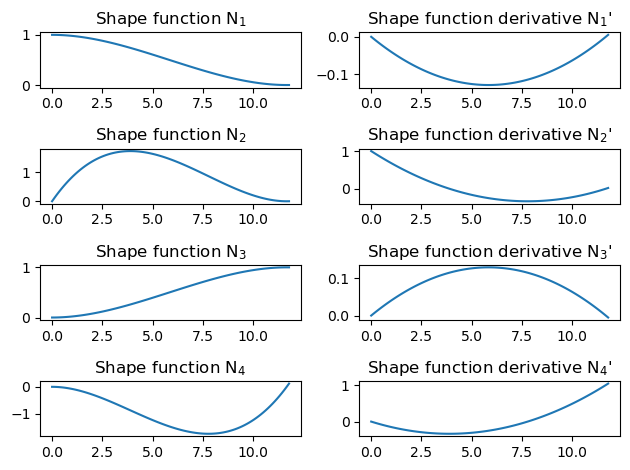

In [ ]:
xplot = np.arange(0, h_e + h_e/100, h_e/100)

fig, axs = plt.subplots(4, 2)
axs[0, 0].plot(xplot, N_k[0](xplot))
axs[0, 0].set_title("Shape function N$_1$")
axs[0, 1].plot(xplot, dN_k[0](xplot))
axs[0, 1].set_title("Shape function derivative N$_1$'")
axs[1, 0].plot(xplot, N_k[1](xplot))
axs[1, 0].set_title("Shape function N$_2$")
axs[1, 1].plot(xplot, dN_k[1](xplot))
axs[1, 1].set_title("Shape function derivative N$_2$'")
axs[2, 0].plot(xplot, N_k[2](xplot))
axs[2, 0].set_title("Shape function N$_3$")
axs[2, 1].plot(xplot, dN_k[2](xplot))
axs[2, 1].set_title("Shape function derivative N$_3$'")
axs[3, 0].plot(xplot, N_k[3](xplot))
axs[3, 0].set_title("Shape function N$_4$")
axs[3, 1].plot(xplot, dN_k[3](xplot))
axs[3, 1].set_title("Shape function derivative N$_4$'")

# automatically fix subplot spacing
plt.tight_layout()

In [ ]:
import scipy.integrate as scp
M_k = np.zeros((4, 4))
K_k = np.zeros((4, 4))
Q_k = np.zeros(4)

for idof in np.arange(0, 4):
    for jdof in np.arange(0, 4):
        def eqn_M(x):
            return rho*A*N_k[idof](x)*N_k[jdof](x)
        def eqn_K(x): 
            return E*I*ddN_k[idof](x)*ddN_k[jdof](x)
        def eqn_Q(x):
            return q*N_k[idof](x)
            
        M_k[idof, jdof] = scp.quad(eqn_M, 0, h_e)[0]
        K_k[idof, jdof] = scp.quad(eqn_K, 0, h_e)[0]
        Q_k[idof] = scp.quad(eqn_Q, 0, h_e)[0]

In [ ]:
K = np.zeros((ndofs*ndofs))       # 1-D array for global stiffness matrix
M = np.zeros((ndofs*ndofs))       # 1-D array for global mass matrix
Q = np.zeros(ndofs)               # 1-D array for Q vector

for ie in np.arange(0, ne):
    # Get the nodes of the elements
    dofs = elem_dofs[ie]
    NodeLeft = dof_node[dofs[0]]
    NodeRight = dof_node[dofs[-1]]
    
    # Get the degrees of freedom that correspond to each node
    Dofs_Left = 2*(NodeLeft) + np.arange(0, 2)
    Dofs_Right = 2*(NodeRight) + np.arange(0, 2)

    # Assemble the matrices at the correct place
    nodes = np.append(Dofs_Left, Dofs_Right)
    for i in np.arange(0, 4):
        Q[nodes[i]] = Q[nodes[i]] + Q_k[i]
        for j in np.arange(0, 4):
            ij = nodes[j] + nodes[i]*ndofs
            M[ij] = M[ij] + M_k[i, j]
            K[ij] = K[ij] + K_k[i, j]
            
# Reshape the global matrix from a 1-D array to a 2-D array
M = M.reshape((ndofs, ndofs))
K = K.reshape((ndofs, ndofs))

# Add RNA mass to the last node
M[-2, -2] = M_RNA

Q

array([ 5.83333333e+01,  1.13425926e+02,  1.16666667e+02, -4.54747351e-13,
        1.16666667e+02, -4.54747351e-13,  1.16666667e+02, -4.54747351e-13,
        1.16666667e+02, -4.54747351e-13,  1.16666667e+02, -4.54747351e-13,
        1.16666667e+02, -4.54747351e-13,  1.16666667e+02, -4.54747351e-13,
        1.16666667e+02, -4.54747351e-13,  1.16666667e+02, -4.54747351e-13,
        1.16666667e+02, -4.54747351e-13,  1.16666667e+02, -4.54747351e-13,
        5.83333333e+01, -1.13425926e+02])

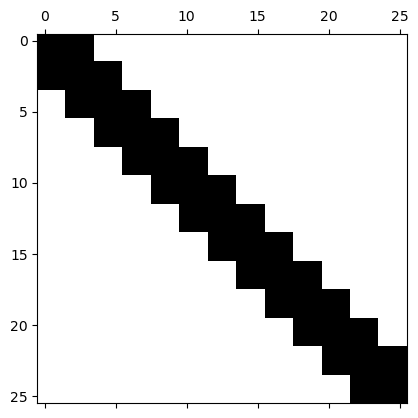

In [ ]:
plt.figure()
plt.spy(M);

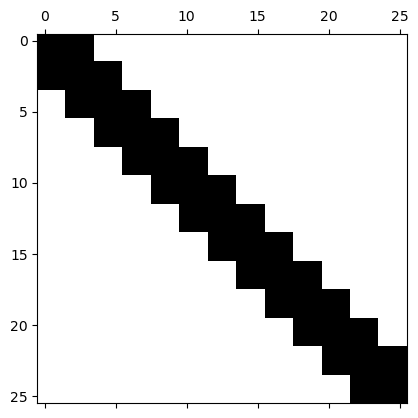

In [ ]:
plt.figure()
plt.spy(K);

In [ ]:
fixed_dofs = np.arange(0, 2)                    # fixed DOFs
free_dofs = np.arange(0, ndofs)                 # free DOFs
free_dofs = np.delete(free_dofs, fixed_dofs)    # remove the fixed DOFs from the free DOFs array

# free & fixed array indices
fx = free_dofs[:, np.newaxis]
fy = free_dofs[np.newaxis, :]
bx = fixed_dofs[:, np.newaxis]
by = fixed_dofs[np.newaxis, :]

# Mass
Mii = M[fx, fy]
Mib = M[fx, by]
Mbi = M[bx, fy]
Mbb = M[bx, by]

# Stiffness
Kii = K[fx, fy]
Kib = K[fx, by]
Kbi = K[bx, fy]
Kbb = K[bx, by]

Qii = Q[fy]
Qbb = Q[by]

Qii

array([[ 1.16666667e+02, -4.54747351e-13,  1.16666667e+02,
        -4.54747351e-13,  1.16666667e+02, -4.54747351e-13,
         1.16666667e+02, -4.54747351e-13,  1.16666667e+02,
        -4.54747351e-13,  1.16666667e+02, -4.54747351e-13,
         1.16666667e+02, -4.54747351e-13,  1.16666667e+02,
        -4.54747351e-13,  1.16666667e+02, -4.54747351e-13,
         1.16666667e+02, -4.54747351e-13,  1.16666667e+02,
        -4.54747351e-13,  5.83333333e+01, -1.13425926e+02]])

### Step 2: Find Natural Frequencies

In [ ]:
mat = np.dot(np.linalg.inv(Mii), Kii)
eigenvalues, eigenvectors = np.linalg.eig(mat)
omega = np.sort(np.sqrt(eigenvalues.real))
f = omega/2/np.pi

print("First 5 natural frequencies:")
for i in np.arange(0,5):
    print(f"Frequency {i+1}: {f[i]:.2f} Hz, {omega[i]:.2f} rad/s")
    
print()
print(f"Omega_max: {Omega_max:.2f} rpm")
print(f"Omega_max: {Omega_max/60:.2f} Hz")
print(f"Omega_max: {2*np.pi*Omega_max/60:.2f} rad/s")

First 5 natural frequencies:
Frequency 1: 0.25 Hz, 1.55 rad/s
Frequency 2: 1.83 Hz, 11.50 rad/s
Frequency 3: 5.47 Hz, 34.39 rad/s
Frequency 4: 11.14 Hz, 69.99 rad/s
Frequency 5: 18.86 Hz, 118.50 rad/s

Omega_max: 11.30 rpm
Omega_max: 0.19 Hz
Omega_max: 1.18 rad/s


In [ ]:
# Rayleigh Damping
zeta1 = zeta2 = 0.02

A_mat = np.array([
    [1/(2*omega[0]), omega[0]/2],
    [1/(2*omega[1]), omega[1]/2]
])
b_vec = np.array([zeta1, zeta2])

alpha, beta = np.linalg.solve(A_mat, b_vec)
print("alpha = ", alpha)
print("beta = ", beta)
C = alpha*M + beta*K
C_ii = C[np.ix_(free_dofs, free_dofs)]

C_ii

alpha =  0.054619150945627276
beta =  0.003065838745751389


array([[ 9.17526462e+07,  9.35452824e-08, -4.58724729e+07,
         2.67592420e+08,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 9.35452824e-08,  4.16261197e+09, -2.67592420e+08,
         1.04064052e+09,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-4.58724729e+07, -2.67592420e+08,  9.17526462e

### Step 3: Sanity Checks

**Complete with analytical expressions and calculations to be compared with the following results**

The displacements resulting from the model are hereby compared with analytical results for a cantilever beam in order to validate the FE implementation.


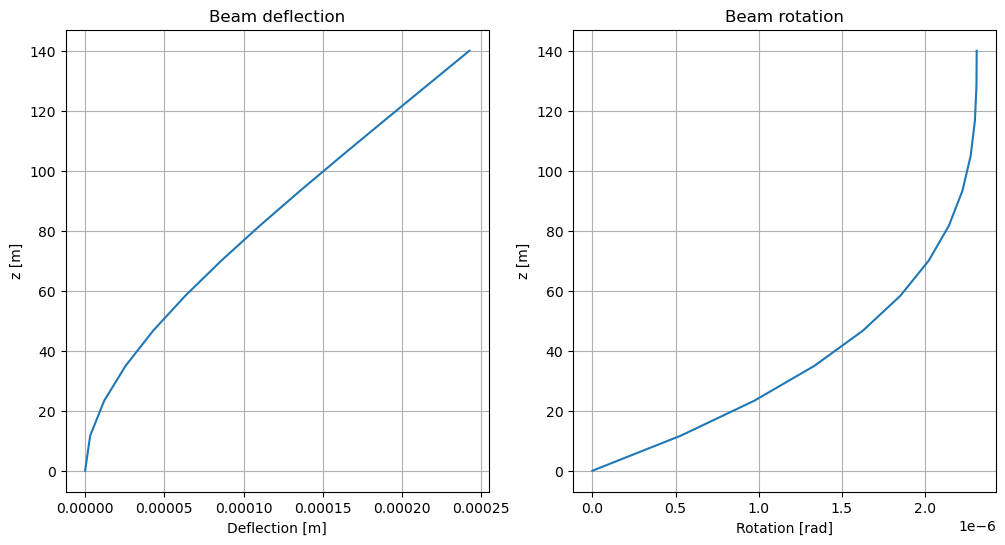

In [ ]:
# Solve for displacements
u = Qii @ np.linalg.inv(Kii)

# Add fixed boundary conditions back in
u_full = np.insert(u, 0, [0,0])

# Plot results
fig, ax = plt.subplots(1,2, figsize=(12, 6))
ax[0].plot(u_full[::2], xn)
ax[0].set_ylabel('z [m]')
ax[0].set_xlabel("Deflection [m]")
ax[0].set_title("Beam deflection");
ax[0].grid()

ax[1].plot(u_full[1::2], xn)
ax[1].set_ylabel('z [m]')
ax[1].set_xlabel("Rotation [rad]")
ax[1].set_title("Beam rotation");
ax[1].grid()


## Question 2: Monopile Diameter Tuning
In order to avoid resonances the first natural frequency of the structure must not coincide with the rotor frequency ($\Omega_{max}$). 
The radius of the monopile is therefore tuned to return a natural frequency approximatedly 10% higher than the 1P frequency ($\Omega_{max}$). 
An arbitrary $D/t$ ratio of 100 was chosen as design parameter. 
A radius of 3.5m was chosen which returns a natural frequency of 0.25 Hz, which is acceptable compared to given $\Omega_{max}$=0.19 Hz. 
Acceptance criterion was a structure natural frequency at least 10% higher than rotor frequency. \
(Previous cells already include the design radius, which was determined by iteration)

#CHECK > Before final delivery make sure radius and frequencies were not modified

## Question 3: Wind and wave co-spectra

* check - mean wind profile along tower height
* ?? - Kaimal spectra over this height for each node
* ?? - corresponding co-spectra for each node
* check - one-dimensional JONSWAP spectra
* check - significant wave heights

In [ ]:
# F_tilde, f_p_tilde, U_10, f_p, g, F = sym.symbols('F_tilde f_p_tilde U_10 f_p g F')
# eq1 = sym.Eq(f_p_tilde, U_10 * f_p / g)
# eq2 = sym.Eq(F_tilde, g * F / U_10**2)
# eq3 = sym.Eq(f_p_tilde, 3.5 / F_tilde**0.33)
# sol = sym.solve([eq1, eq2, eq3], (U_10, F_tilde, f_p_tilde), dict=True)
# '''[{
# F_tilde: 0.000630376100157691*F*f_p**2/(g*(g**33/(F**33*f_p**66))**(1/17)),
# U_10: 39.8290667529805*g*(g**33/(F**33*f_p**66))**(1/34)/f_p,
# f_p_tilde: 39.8290667529805*(g**33/(F**33*f_p**66))**(1/34)
# }]'''

In [ ]:
# sol

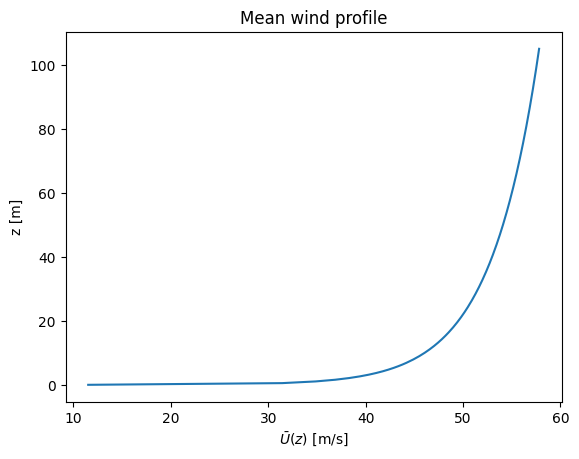

In [ ]:
def U_bar(z, u_star, k, z_0):
    return u_star / k * np.log(z / z_0)

z_wind = np.linspace(0.01, H, 200)
U_bar_values = U_bar(z_wind, u_star, k, z_0)
plt.plot(U_bar_values, z_wind)
plt.xlabel('$\\bar{U}(z)$ [m/s]')
plt.ylabel('z [m]')
plt.title('Mean wind profile');

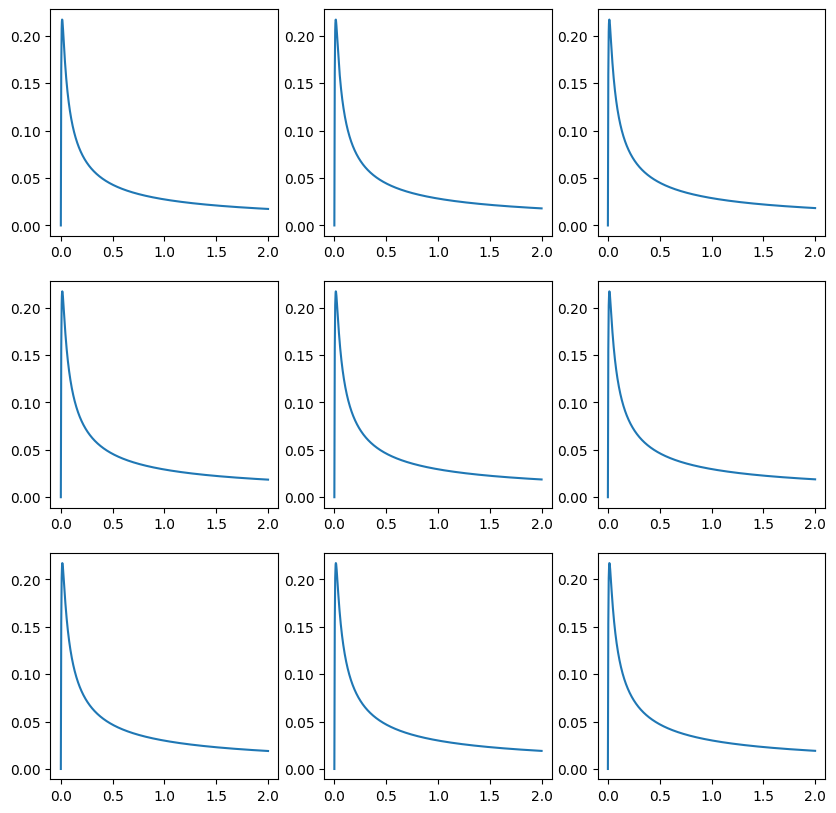

In [ ]:
C = 500 #belonging to z0=1e-3
m = 0.03 #belonging to z0=1e-3

def L_u_x(z, C, m):
    return C * z**m

def Kaimal(z, f, C, m, u_star, k, z_0):
    f_L = f * L_u_x(z, C, m) / U_bar(z, u_star, k, z_0)
    return 6.8 * f_L / (1 + 10.2 * f_L)**(5 / 3)

z_nodes = np.linspace(-h, H, 13)
z_nodes_air = z_nodes[z_nodes > 0]
f = np.linspace(0, 2, 1000)

plt.figure(figsize=(10, 10))
for i,z in enumerate(z_nodes_air):
    plt.subplot(3, 3, i + 1)
    R_N = Kaimal(z, f, C, m, u_star, k, z_0)
    plt.plot(f, R_N)

0.23493791626408858 0.13962667220798897


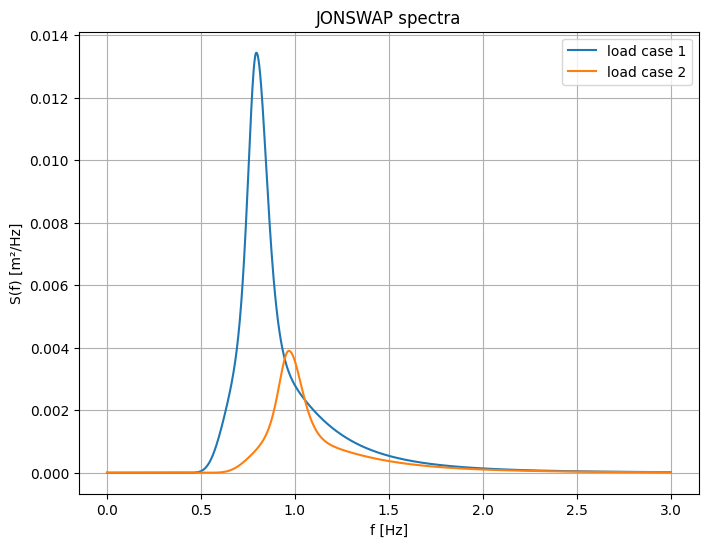

In [ ]:
#Load case 1: resonance response
omega_n1 = 5 #CHANGE
f_p_1 = omega_n1 / (2 * np.pi)
T_p_1 = 1 / f_p_1
U_10_1 = 39.8290667529805 * g * (g**33 / (F**33 * f_p_1**66))**(1 / 34) / f_p_1
F_tilde_1 = g * F / U_10_1**2
f_p_tilde_1 = 3.5 * F_tilde_1**(-0.33)
alpha_1 = 0.076 * F_tilde_1**(-0.22)

#Load case 2: idling in operational conditions
U_10_2 = 23 #m/s
F_tilde_2 = g * F / U_10_2**2
f_p_tilde_2 = 3.5 * F_tilde_2**(-0.33)
f_p_2 = f_p_tilde_2 * g / U_10_2
T_p_2 = 1 / f_p_2
alpha_2 = 0.076 * F_tilde_2**(-0.22)

gamma = 3.3
beta = 5 / 4

def JONSWAP(alpha, g, f, beta, f_p, gamma):
    sigma = 0.07 * np.ones_like(f)
    sigma[f > f_p] = 0.09

    S = alpha * g**2 * (2 * np.pi)**(-4) * f**(-5) * np.exp(-beta * (f / f_p)**(-4)) * gamma**np.exp(-1 / 2 * ((f / f_p - 1) / sigma)**2)
    m_0 = np.trapezoid(S, f)
    H_s = 4 * np.sqrt(m_0)

    return S, H_s

f = np.linspace(0.001, 10, 5000)
f_max = 3
S_JS_1, H_s_1 = JONSWAP(alpha_1, g, f, beta, f_p_1, gamma)
S_JS_2, H_s_2 = JONSWAP(alpha_2, g, f, beta, f_p_2, gamma)

plt.figure(figsize=(8, 6))
plt.plot(f[f < f_max], S_JS_1[f < f_max], label='load case 1')
plt.plot(f[f < f_max], S_JS_2[f < f_max], label='load case 2')
plt.title(f'JONSWAP spectra')
plt.xlabel('f [Hz]')
plt.ylabel('S(f) [m²/Hz]')
plt.legend()
plt.grid()

print(H_s_1, H_s_2)

## Question 4: Wind and waves timeseries and convergence analysis

Generate times series for wind and waves (plus convergence analysis) 


Based on the Kaimal and JONSWAP spectra, times series of the wind and wave kinematics are 
determined for each node of the finite element model. To this end, random phase angle 
distributions can be adopted. Time series representations should be sufficiently long to capture 
the statistical properties of the applied wind and wave spectra. Furthermore, the sampling 
period should be sufficiently small to adequately capture the first and second mode of the 
structure

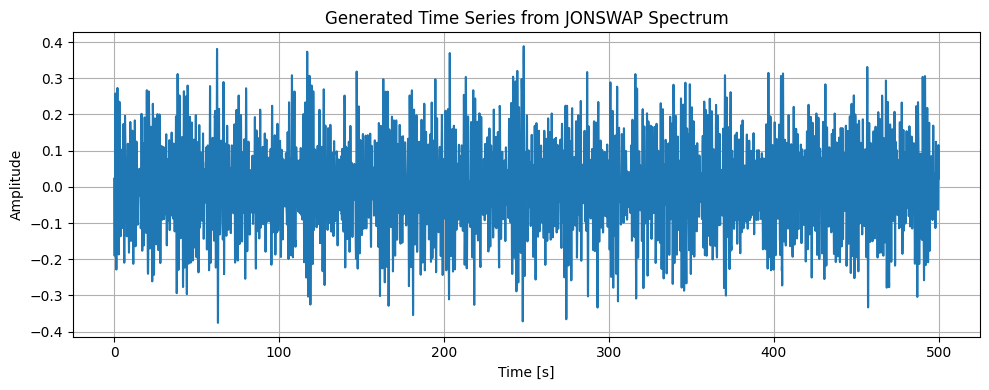

In [ ]:
# Parameters
N = 5000                         # Number of frequency points
f = np.linspace(0.001, 10, N)    # Frequency vector
df = f[1] - f[0]                 # Frequency resolution

# Compute JONSWAP spectrum
S, H_s = JONSWAP(alpha_1, g, f, beta, f_p_1, gamma)

# Compute amplitudes A_n
A = np.sqrt(2 * S * df)

# Generate random phase angles θ_n
theta = np.random.uniform(0, 2*np.pi, N)

# Construct complex Fourier coefficients X_n
X_pos = A * np.exp(1j * theta)

# Include X_0 = 0 (zero mean)
X_0 = np.array([0.0])

# Create full spectrum: [X_0, X_1, ..., X_N, conj(X_N), ..., conj(X_1)]
X_full = np.concatenate([X_0, X_pos, np.conj(X_pos[::-1])])

# Apply scaling
X_full *= len(X_full)

# Inverse Fourier Transform to get time series
x_t1 = np.fft.ifft(X_full).real  # Take real part only

# Time vector
T = 1 / df
dt = T / len(X_full)
t = np.linspace(0, T, len(X_full))

# Plot time series
plt.figure(figsize=(10, 4))
plt.plot(t, x_t1)
plt.title("Generated Time Series from JONSWAP Spectrum")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.grid(True)
plt.tight_layout()
plt.show()

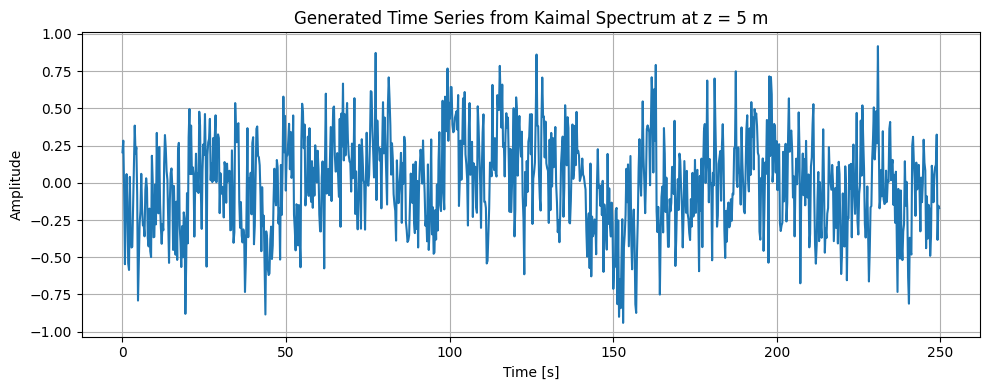

In [ ]:

# Constants
u_star = 0.3      # Friction velocity [m/s]
k = 0.4           # von Karman constant
z_0 = 1e-3        # Roughness length [m]
C = 500
m = 0.03

# Frequency vector
N = 500
f = np.linspace(0.001, 2, N)
Δf = f[1] - f[0]

# Pick a height (e.g., 10 m)
z = 5
S = Kaimal(z, f, C, m, u_star, k, z_0)

# Generate amplitudes and random phases
A = np.sqrt(2 * S * Δf)
theta = np.random.uniform(0, 2 * np.pi, N)
X_pos = A * np.exp(1j * theta)

# Assemble full symmetric spectrum for real time series
X_0 = np.array([0.0])
X_full = np.concatenate([X_0, X_pos, np.conj(X_pos[::-1])])
X_full *= len(X_full)  # scale

# Inverse Fourier transform
x_t2 = np.fft.ifft(X_full).real

# Time vector
T = 1 / Δf
dt = T / len(X_full)
t = np.linspace(0, T, len(X_full))

# Plot
plt.figure(figsize=(10, 4))
plt.plot(t, x_t2)
plt.title(f"Generated Time Series from Kaimal Spectrum at z = {z} m")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.grid(True)
plt.tight_layout()
plt.show()


c:\Users\Menno Marissen\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\signal\_spectral_py.py:790: UserWarning: nperseg = 1024 is greater than input length  = 1001, using nperseg = 1001
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
c:\Users\Menno Marissen\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\signal\_spectral_py.py:790: UserWarning: nperseg = 2048 is greater than input length  = 1001, using nperseg = 1001
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
c:\Users\Menno Marissen\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\signal\_spectral_py.py:790: UserWarning: nperseg = 4096 is greater than input length  = 1001, using nperseg = 1001
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


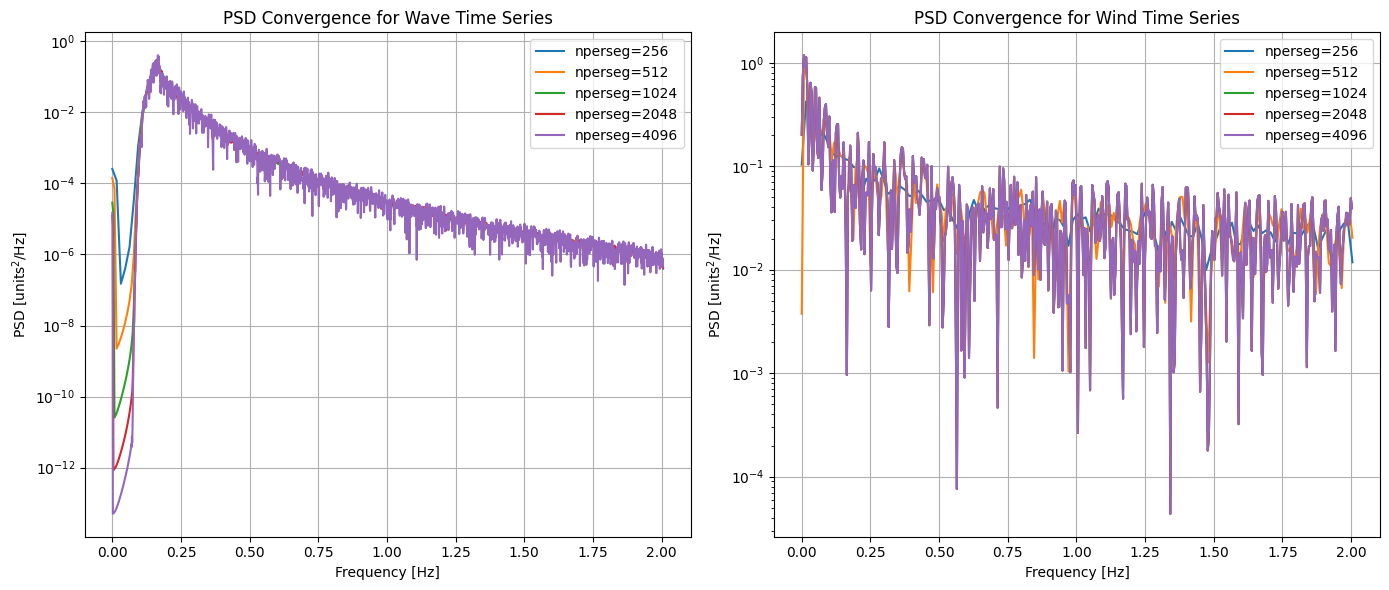

In [ ]:

# Define a range of segment lengths (number of samples) for Welch's method
segment_lengths = [256, 512, 1024, 2048, 4096]

plt.figure(figsize=(14, 6))

# Wave time series PSD convergence
plt.subplot(1, 2, 1)
for nperseg in segment_lengths:
    f_w, Pxx_w = welch(x_t1, fs=1/dt, nperseg=nperseg)
    plt.semilogy(f_w, Pxx_w, label=f'nperseg={nperseg}')
plt.title('PSD Convergence for Wave Time Series')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD [units$^2$/Hz]')
plt.legend()
plt.grid(True)

# Wind time series PSD convergence
plt.subplot(1, 2, 2)
for nperseg in segment_lengths:
    f_wind, Pxx_wind = welch(x_t2, fs=1/dt, nperseg=nperseg)
    plt.semilogy(f_wind, Pxx_wind, label=f'nperseg={nperseg}')
plt.title('PSD Convergence for Wind Time Series')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD [units$^2$/Hz]')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()